In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
IDX = 13
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

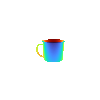

In [34]:
img = b.RENDERER.render(table_pose[None,...], jnp.array([13]))
b.get_depth_image(img[...,2]).convert("RGB")

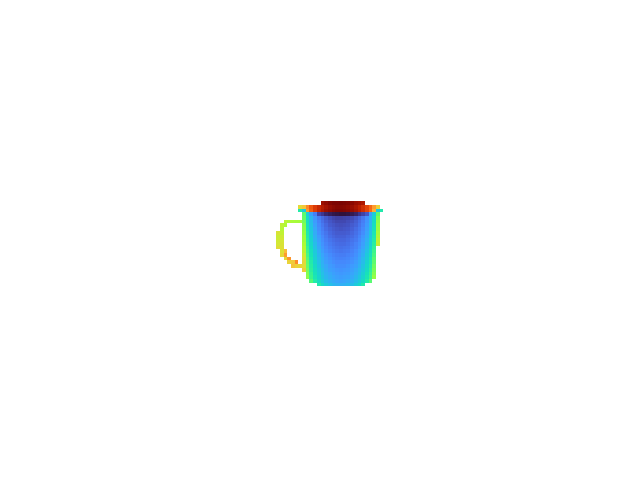

(37, 49)


In [35]:
%matplotlib widget
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = None
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', s=10)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [36]:
coordinate = img[location[1],location[0],:3]
b.clear()
b.show_cloud("data", img[:,:,:3].reshape(-1,3))
b.show_cloud("point", coordinate.reshape(-1,3), color=b.RED)
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]
b.show_cloud("obj", b.RENDERER.meshes[IDX].vertices *5.0)
b.show_cloud("point2", coordinate_in_object_frame.reshape(-1,3) * 5.0, color=b.RED)

In [37]:
random_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(10),2000), table_pose, 0.01, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

img = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([13]))
rendered_points = img[jnp.arange(img.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3]
distances = jnp.linalg.norm(rendered_points- coordinates[:,:3],axis=-1)

1053
0.52650005
0.0003880836


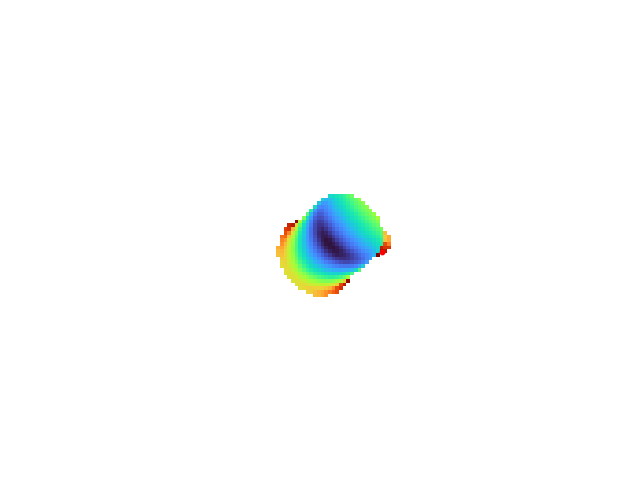

In [38]:
valid_indices = distances < 0.01
print(valid_indices.sum())
print(valid_indices.sum() / valid_indices.shape[0])
i = distances.argsort()[10]
b.clear()
b.show_cloud("data", img[i,:,:,:3].reshape(-1,3))
b.show_cloud("point2", rendered_points[i].reshape(-1,3), color=b.RED)
b.show_cloud("point", coordinates[i,:3].reshape(-1,3), color=b.BLUE)
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]

print(distances[i])
fig = b.viz_depth_image(img[i,...,2])
fig.get_axes()[0].scatter(pixel_coordinates[i,0], pixel_coordinates[i,1], c='r', s=10)

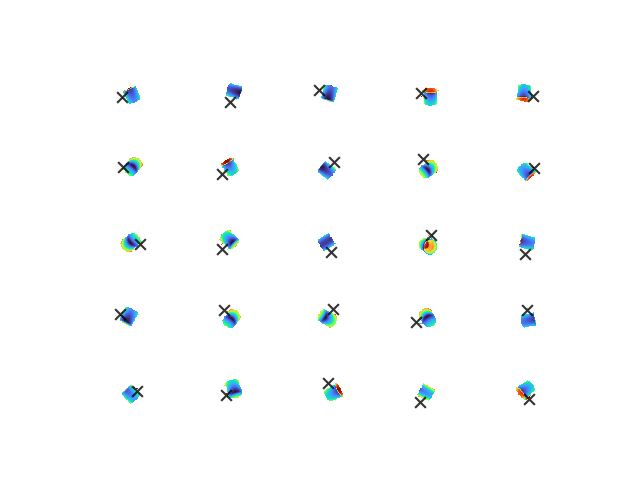

In [61]:
fig = plt.figure()
N = 25
for j in range(N):
    ax = fig.add_subplot(5,5,j+1)
    i = distances.argsort()[j]
    b.add_depth_image(ax, img[i,...,2])
    # ax.axis("on")
    ax.scatter(pixel_coordinates[i,0], pixel_coordinates[i,1], c='black', alpha=0.8,s=60, marker='x')
# plt.subplots_adjust(top = 0.0, bottom=0.0, hspace=0.1, wspace=0.4)
plt.subplots_adjust(wspace=0, hspace=0)

In [77]:
img[jnp.arange(img.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3] - coordinates

TypeError: sub got incompatible shapes for broadcasting: (100, 3), (100, 4).

In [54]:
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = b.camera.project_cloud_to_pixels(coordinates, intrinsics).astype(jnp.int32)


In [ ]:
images =

In [44]:
pixel_coordinates = b.camera.project_cloud_to_pixels(b.apply_transform(coordinate_in_object_frame.reshape(-1,3), random_pose), intrinsics).astype(jnp.int32)


ValueError: Einstein sum subscript 'ij' does not contain the correct number of indices for operand 0.